In [4]:
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from python_speech_features import logfbank
import os
import librosa
import librosa.display
from scipy.io.wavfile import write
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras import Input,layers,Model
from keras.layers import  Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, \
BatchNormalization, Activation, Concatenate,Reshape,multiply,Lambda,GlobalAveragePooling2D
from keras import optimizers

In [59]:
depr_2s=np.load("data/depr_2s.npy")
nor_2s=np.load("data/nor_2s.npy")
depr_3s=np.load("data/depr_3s.npy")
nor_3s=np.load("data/nor_3s.npy")
def balance(depr,nor):
    balance_size=min(depr.shape[0],nor.shape[0])
    return (depr[0:balance_size,:,:] ,nor[0:balance_size,:,:])
##裁切depr和nor语料数量，使之平衡
depr_2s,nor_2s=balance(depr_2s,nor_2s)
depr_3s,nor_3s=balance(depr_3s,nor_3s)
x_2s=np.concatenate((depr_2s,nor_2s),axis=0)
x_2s=x_2s.reshape(*x_2s.shape,1)
x_3s=np.concatenate((depr_3s,nor_3s),axis=0)
x_3s=x_3s.reshape(*x_3s.shape,1)
y_2s=np.concatenate((np.ones(depr_2s.shape[0]),np.zeros(depr_2s.shape[0])),axis=0)
y_3s=np.concatenate((np.ones(depr_3s.shape[0]),np.zeros(depr_3s.shape[0])),axis=0)
folds=list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(x_2s, y_2s))
##得到k=7folds的标签，然后分别用kfolds验证模型的效果

In [63]:
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
def get_model():
    input_tensor=Input(shape=(128,63,1))
    conv1a=layers.Conv2D(8,(2,8),activation='relu',padding='same')(input_tensor)
    conv1b=layers.Conv2D(8,(8,2),activation='relu',padding='same')(input_tensor)
    conv1 = layers.concatenate([conv1a,conv1b],axis=-1)
    MaxPooling=layers.MaxPooling2D(2,2)(conv1)
    conv2=layers.Conv2D(32,(3,3),activation='relu',padding = 'same')(MaxPooling)
    MaxPooling=layers.MaxPooling2D(2,2)(conv2)
    conv3=layers.Conv2D(48,(3,3),activation='relu',padding = 'same')(MaxPooling)
    MaxPooling=layers.MaxPooling2D(2,2)(conv3)
    conv4=layers.Conv2D(64,(3,3),activation='relu',padding = 'same')(MaxPooling)
    MaxPooling=layers.MaxPooling2D(2,2)(conv4)
    conv5a=layers.Conv2D(1,(1,1),activation='relu',padding='same')(MaxPooling)
    conv5b=layers.Conv2D(1,(1,1),activation='sigmoid',padding='same')(MaxPooling)
    Multiply= multiply([conv5a,conv5b])
    output_tensor=layers.GlobalAveragePooling2D()(Multiply)
    API_model=Model(input_tensor,output_tensor)
    API_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return API_model

In [50]:
API_model=get_model()
API_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 63, 1)   0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 128, 63, 8)   136         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 128, 63, 8)   136         input_10[0][0]                   
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 128, 63, 16)  0           conv2d_64[0][0]                  
                                                                 conv2d_65[0][0]                  
__________

In [64]:
x_train_2s,x_test_2s,y_train_2s,y_test_2s=train_test_split(x_2s,y_2s,test_size=0.3,random_state=7)

In [52]:
sgd = optimizers.SGD(lr=0.001, clipnorm=1.)
input_tensor=Input(shape=(128,63,1))
conv1a=layers.Conv2D(8,(2,8),activation='relu',padding='same')(input_tensor)
conv1b=layers.Conv2D(8,(8,2),activation='relu',padding='same')(input_tensor)
conv1 = layers.concatenate([conv1a,conv1b],axis=-1)
MaxPooling=layers.MaxPooling2D(2,2)(conv1)
conv2=layers.Conv2D(32,(3,3),activation='relu',padding = 'same')(MaxPooling)
conv2=BatchNormalization()(conv2)
MaxPooling=layers.MaxPooling2D(2,2)(conv2)
conv3=layers.Conv2D(48,(3,3),activation='relu',padding = 'same')(MaxPooling)
conv3=BatchNormalization()(conv3)
MaxPooling=layers.MaxPooling2D(2,2)(conv3)
conv4=layers.Conv2D(64,(3,3),activation='relu',padding = 'same')(MaxPooling)
conv4=BatchNormalization()(conv4)
MaxPooling=layers.MaxPooling2D(2,2)(conv4)
conv5a=layers.Conv2D(1,(1,1),activation='relu',padding='same')(MaxPooling)
conv5b=layers.Conv2D(1,(1,1),activation='sigmoid',padding='same')(MaxPooling)
Multiply= multiply([conv5a,conv5b])
output_tensor=layers.GlobalAveragePooling2D()(Multiply)
API_model=Model(input_tensor,output_tensor)
API_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
API_model=get_model()
history=API_model.fit(x_train_2s,y_train_2s,validation_data=(x_test_2s,y_test_2s),epochs=150,batch_size=64)

Train on 9937 samples, validate on 4259 samples
Epoch 1/150
9937/9937 [==============================] - 43s 4ms/step - loss: 0.6662 - acc: 0.6263 - val_loss: 0.6360 - val_acc: 0.6443
Epoch 2/150
9937/9937 [==============================] - 39s 4ms/step - loss: 0.6238 - acc: 0.6546 - val_loss: 0.6496 - val_acc: 0.5832
Epoch 3/150
9937/9937 [==============================] - 43s 4ms/step - loss: 0.6052 - acc: 0.6787 - val_loss: 0.5963 - val_acc: 0.6753
Epoch 4/150
9937/9937 [==============================] - 41s 4ms/step - loss: 0.5954 - acc: 0.6837 - val_loss: 0.5921 - val_acc: 0.6924
Epoch 5/150
9937/9937 [==============================] - 40s 4ms/step - loss: 0.6069 - acc: 0.6697 - val_loss: 0.5881 - val_acc: 0.6887
Epoch 6/150
9937/9937 [==============================] - 41s 4ms/step - loss: 0.5838 - acc: 0.6895 - val_loss: 0.5791 - val_acc: 0.6931
Epoch 7/150
9937/9937 [==============================] - 40s 4ms/step - loss: 0.5780 - acc: 0.6946 - val_loss: 0.5948 - val_acc: 0.6929


9937/9937 [==============================] - 42s 4ms/step - loss: 0.5951 - acc: 0.6896 - val_loss: 0.5820 - val_acc: 0.7128
Epoch 61/150
9937/9937 [==============================] - 42s 4ms/step - loss: 0.5683 - acc: 0.7116 - val_loss: 0.5676 - val_acc: 0.7128
Epoch 62/150
9937/9937 [==============================] - 42s 4ms/step - loss: 0.7619 - acc: 0.5984 - val_loss: 0.7457 - val_acc: 0.5032
Epoch 63/150
9937/9937 [==============================] - 42s 4ms/step - loss: 0.6479 - acc: 0.6381 - val_loss: 0.6157 - val_acc: 0.6898
Epoch 64/150
9937/9937 [==============================] - 40s 4ms/step - loss: 0.5838 - acc: 0.6999 - val_loss: 0.5721 - val_acc: 0.7166
Epoch 65/150
9937/9937 [==============================] - 40s 4ms/step - loss: 0.5594 - acc: 0.7165 - val_loss: 0.5543 - val_acc: 0.7194
Epoch 66/150
9937/9937 [==============================] - 41s 4ms/step - loss: 0.5521 - acc: 0.7215 - val_loss: 0.5476 - val_acc: 0.7241
Epoch 67/150
9937/9937 [==============================

Epoch 120/150
9937/9937 [==============================] - 39s 4ms/step - loss: 0.6494 - acc: 0.6709 - val_loss: 0.5839 - val_acc: 0.7060
Epoch 121/150
9937/9937 [==============================] - 39s 4ms/step - loss: 0.5178 - acc: 0.7474 - val_loss: 0.5148 - val_acc: 0.7631
Epoch 122/150
9937/9937 [==============================] - 39s 4ms/step - loss: 0.5056 - acc: 0.7532 - val_loss: 0.5840 - val_acc: 0.7206
Epoch 123/150
9937/9937 [==============================] - 39s 4ms/step - loss: 0.5514 - acc: 0.7181 - val_loss: 0.5303 - val_acc: 0.7506
Epoch 124/150
9937/9937 [==============================] - 39s 4ms/step - loss: 0.5198 - acc: 0.7457 - val_loss: 0.5138 - val_acc: 0.7342
Epoch 125/150
9937/9937 [==============================] - 39s 4ms/step - loss: 0.4884 - acc: 0.7739 - val_loss: 0.4960 - val_acc: 0.7591
Epoch 126/150
9937/9937 [==============================] - 39s 4ms/step - loss: 0.5021 - acc: 0.7566 - val_loss: 0.5017 - val_acc: 0.7558
Epoch 127/150
9937/9937 [=========

History可视化

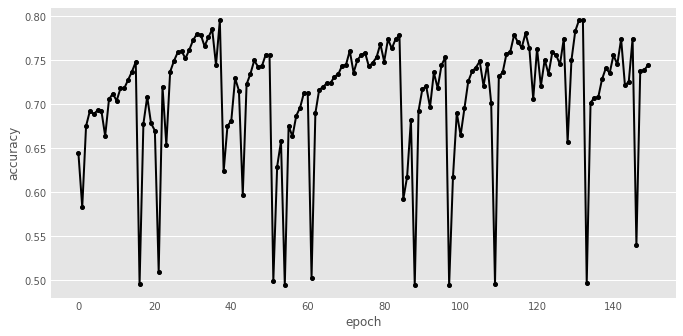

In [164]:
plt.figure(figsize=(10,5))
line=plt.plot(history.history['val_acc'],'ok-',label='baseline')
plt.style.use('ggplot')
plt.setp(line,linestyle='-',marker='o',markersize=4,linewidth=2) 
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(axis='x')

模型不稳定

In [105]:
pd.DataFrame(history.history).to_pickle('data/history_baseline.pkl')
df=pd.read_pickle('data/history_baseline.pkl')

#### 七折交叉验证

In [ ]:
history=[]
score=0
count=0
for i in folds:
    x_train=x_2s[i[0]]
    x_test=x_2s[i[1]]
    y_train=y_2s[i[0]]
    y_test=y_2s[i[1]]
    API_model=get_model()
    history.append(API_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=64))
    score=score+API_model.evaluate(x_test,y_test)[1]
    count=count+1
print(avg_score=score/count)

In [20]:
input_tensor=Input(shape=(128,63,1))
conv1a=layers.Conv2D(8,(2,8),activation='relu',padding='same')(input_tensor)
conv1b=layers.Conv2D(8,(8,2),activation='relu',padding='same')(input_tensor)
conv1 = layers.concatenate([conv1a,conv1b],axis=-1)
MaxPooling=layers.MaxPooling2D(2,2)(conv1)
conv2=layers.Conv2D(32,(3,3),activation='relu',padding = 'same')(MaxPooling)
MaxPooling=layers.MaxPooling2D(2,2)(conv2)
conv3=layers.Conv2D(48,(3,3),activation='relu',padding = 'same')(MaxPooling)
MaxPooling=layers.MaxPooling2D(2,2)(conv3)
conv4=layers.Conv2D(64,(3,3),activation='relu',padding = 'same')(MaxPooling)
MaxPooling=layers.MaxPooling2D(2,2)(conv4)
conv5a=layers.Conv2D(1,(1,1),activation='relu',padding='same')(MaxPooling)
conv5b=layers.Conv2D(1,(1,1),activation='sigmoid',padding='same')(MaxPooling)
Multiply= multiply([conv5a,conv5b])
output_tensor=layers.GlobalAveragePooling2D()(Multiply)
sgd = optimizers.SGD(lr=0.05, clipnorm=1.)
API_model=Model(input_tensor,output_tensor)
API_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])